In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import anndata as ad

In [2]:
adata1 = sc.read_10x_mtx('../data/unzip/GSE229103/', prefix = 'GSM7152484_JHW1_')
adata2 = sc.read_10x_mtx('../data/unzip/GSE229103/', prefix = 'GSM7152485_JHW3_')
adata = ad.concat({'embryo_rep1' : adata1, 'embryo_rep2' : adata2}, label = 'sample')
adata.obs_names_make_unique()

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 48694 × 32286
    obs: 'sample'

In [4]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('Rps', 'Rpl'))

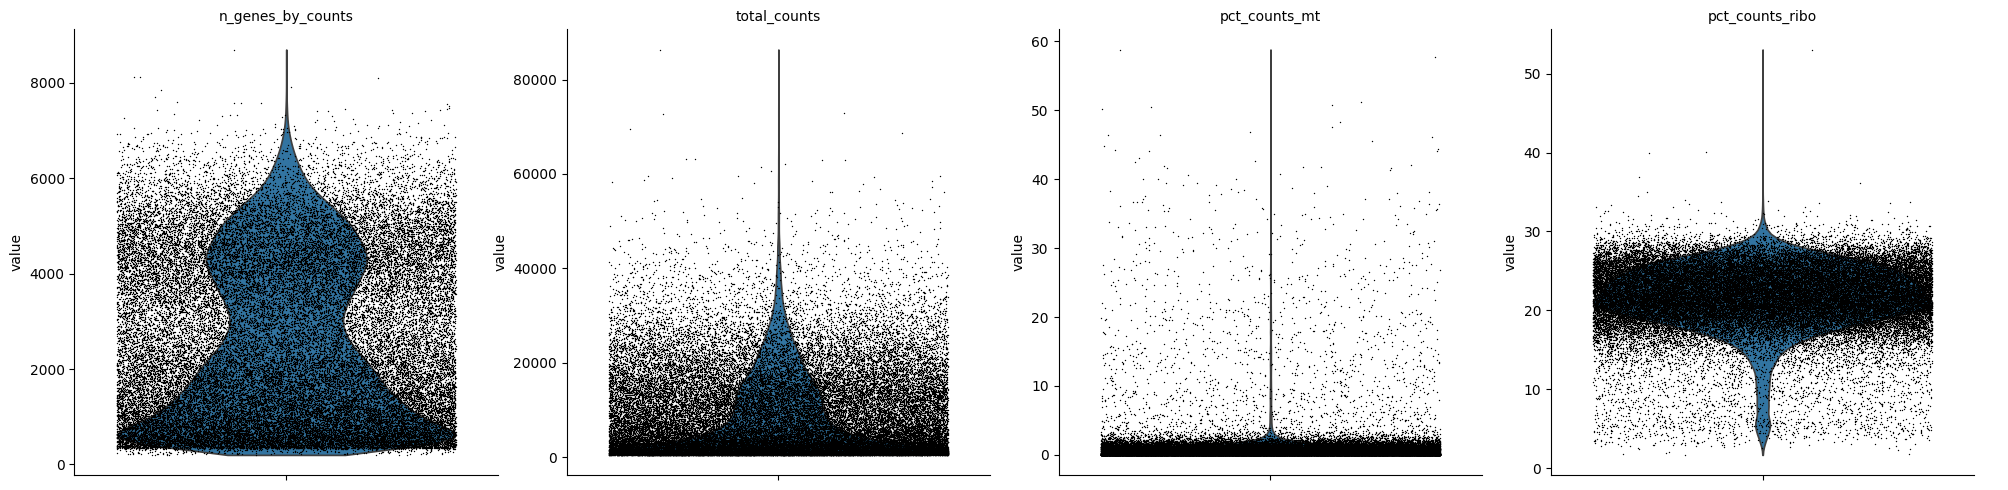

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt', 'ribo'], percent_top = None, inplace = True, log1p = False)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter = .4, multi_panel = True)

In [7]:
adata = adata[
    (adata.obs.total_counts >= 10000) &
    (adata.obs.total_counts <= 50000) &
    (adata.obs.pct_counts_mt <= 2.5) &
    (adata.obs.pct_counts_ribo <= 25) &
    (adata.obs.n_genes_by_counts >= 3000)]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 16097 × 21592
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:
sc.pp.normalize_total(adata, target_sum = 10000)
sc.pp.log1p(adata)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3199 over-dispersed features (0:00:06) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



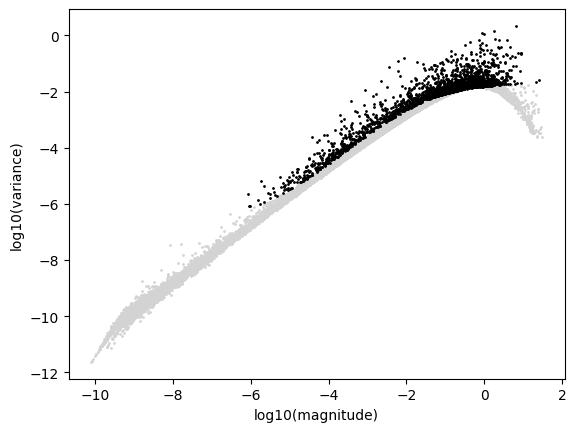

In [10]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [12]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-05-14 16:34:28,841 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-14 16:34:34,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-14 16:34:34,451 - harmonypy - INFO - Iteration 1 of 10
2025-05-14 16:34:40,369 - harmonypy - INFO - Iteration 2 of 10
2025-05-14 16:34:46,240 - harmonypy - INFO - Iteration 3 of 10
2025-05-14 16:34:52,218 - harmonypy - INFO - Iteration 4 of 10
2025-05-14 16:34:58,291 - harmonypy - INFO - Iteration 5 of 10
2025-05-14 16:35:01,746 - harmonypy - INFO - Iteration 6 of 10
2025-05-14 16:35:04,013 - harmonypy - INFO - Iteration 7 of 10
2025-05-14 16:35:06,150 - harmonypy - INFO - Iteration 8 of 10
2025-05-14 16:35:08,344 - harmonypy - INFO - Iteration 9 of 10
2025-05-14 16:35:10,357 - harmonypy - INFO - Converged after 9 iterations


In [13]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = .5)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2575866/3992902431.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = .5)


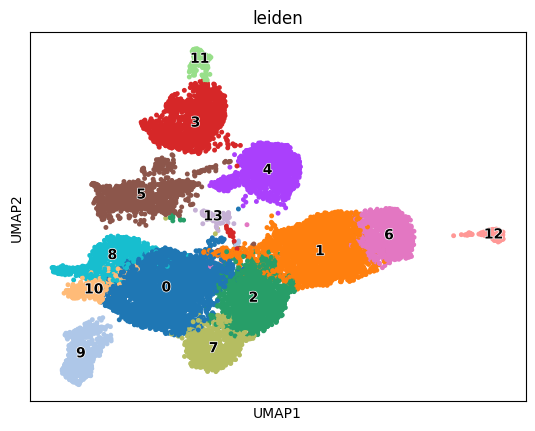

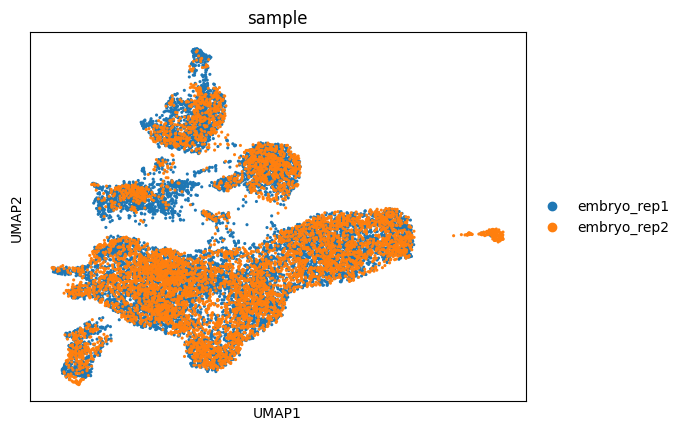

In [14]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'sample', size = 20)

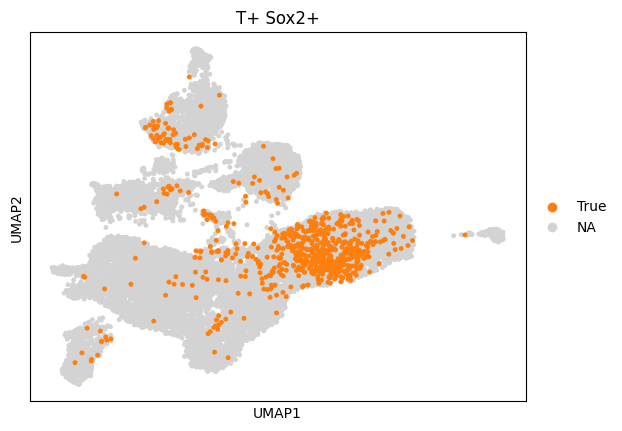

In [15]:
adata.obs['T+ Sox2+'] = np.all(adata[:, ['T', 'Sox2']].X.toarray() > 0, axis = 1).astype(str)
sc.pl.umap(adata, color = 'T+ Sox2+', size = 50, groups = ['True'])

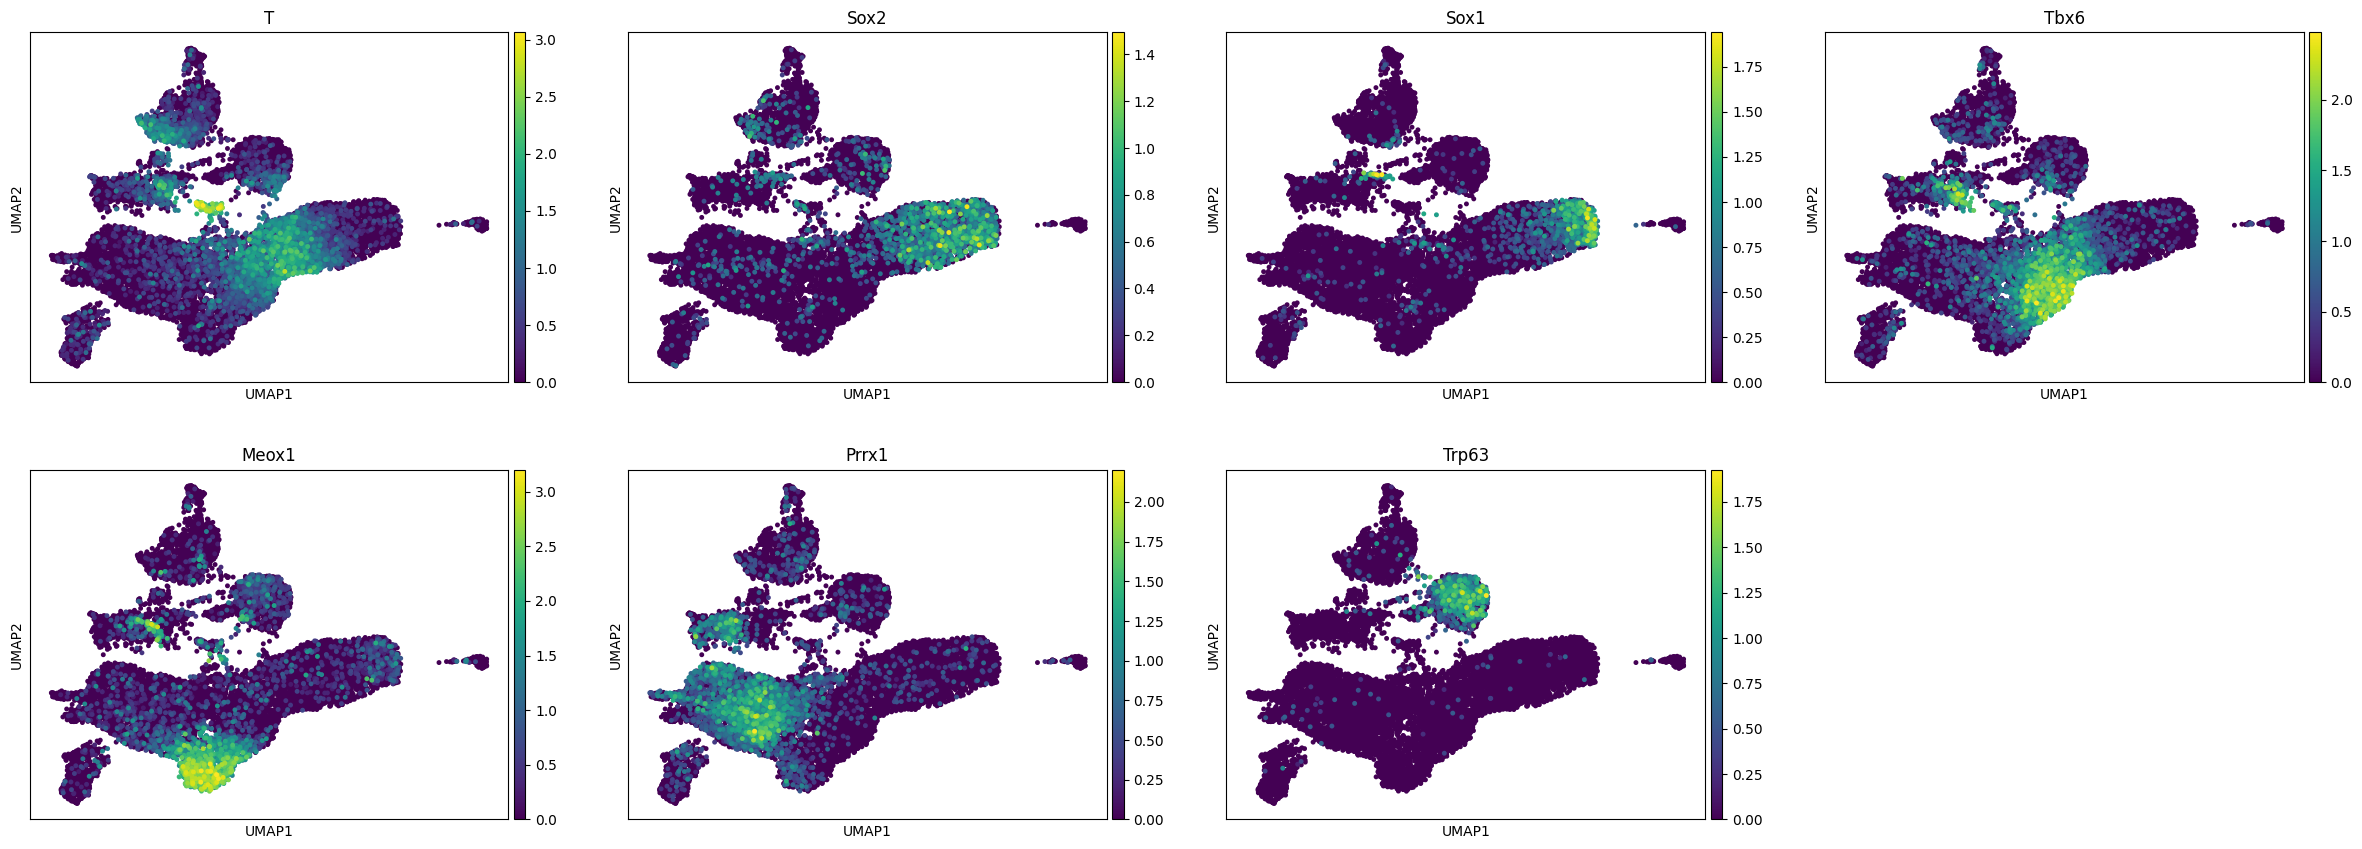

In [24]:
sc.pl.umap(adata, color = ['T', 'Sox2', 'Sox1', 'Tbx6', 'Meox1', 'Prrx1', 'Trp63'], size = 50)

In [25]:
keep = np.array([6, 1, 2, 7, 0, 4], dtype = str)
adata = adata[adata.obs.leiden.isin(keep), :]

In [26]:
adata

View of AnnData object with n_obs × n_vars = 11255 × 21072
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'T+ Sox2+'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', 'T+ Sox2+_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2836 over-dispersed features (0:00:05) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



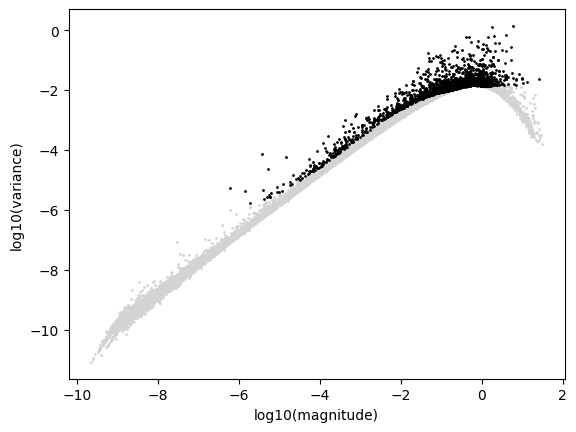

In [27]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [28]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-05-14 16:53:47,194 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-14 16:53:51,442 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-14 16:53:51,738 - harmonypy - INFO - Iteration 1 of 10
2025-05-14 16:53:56,127 - harmonypy - INFO - Iteration 2 of 10
2025-05-14 16:54:00,607 - harmonypy - INFO - Iteration 3 of 10
2025-05-14 16:54:05,328 - harmonypy - INFO - Iteration 4 of 10
2025-05-14 16:54:09,632 - harmonypy - INFO - Iteration 5 of 10
2025-05-14 16:54:13,801 - harmonypy - INFO - Iteration 6 of 10
2025-05-14 16:54:15,662 - harmonypy - INFO - Iteration 7 of 10
2025-05-14 16:54:18,838 - harmonypy - INFO - Iteration 8 of 10
2025-05-14 16:54:21,308 - harmonypy - INFO - Iteration 9 of 10
2025-05-14 16:54:23,534 - harmonypy - INFO - Iteration 10 of 10
2025-05-14 16:54:25,299 - harmonypy - INFO - Converged after 10 iterations


In [29]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = .5)

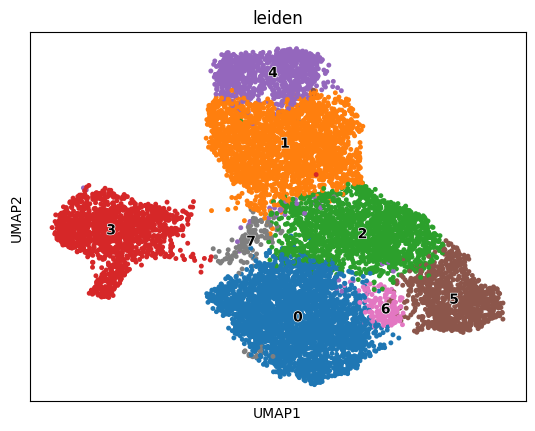

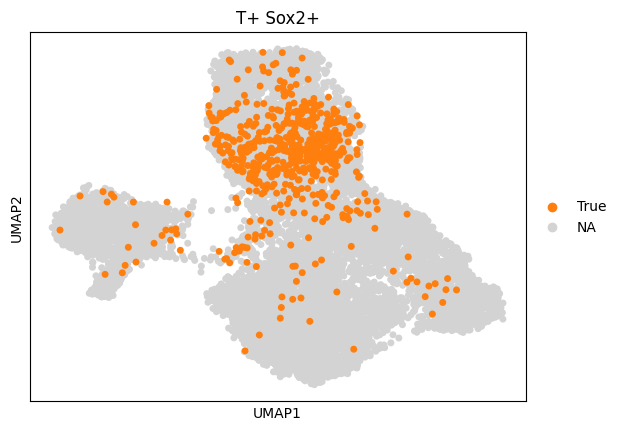

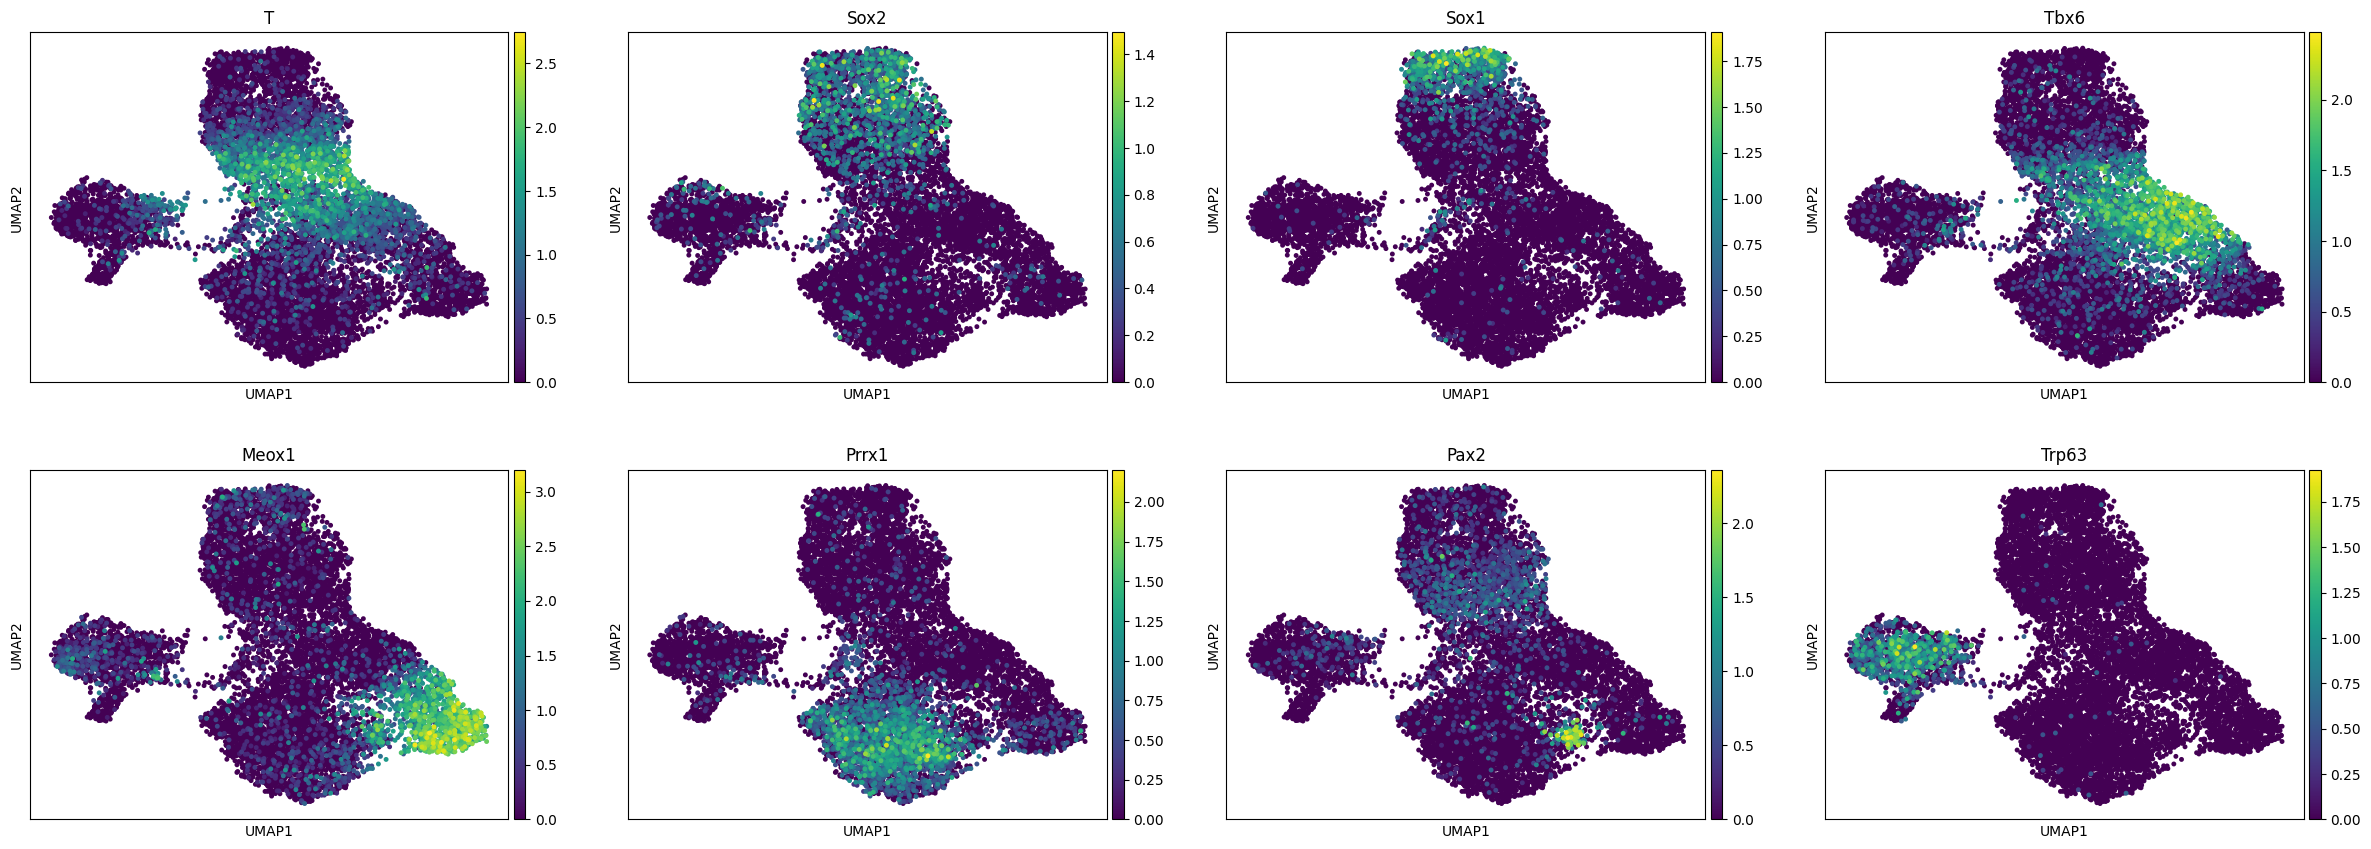

In [32]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'T+ Sox2+', size = 100, groups = ['True'])
sc.pl.umap(adata, color = ['T', 'Sox2', 'Sox1', 'Tbx6', 'Meox1', 'Prrx1', 'Pax2', 'Trp63'], size = 50)

In [33]:
celltype_dict = {
    '1' : 'Neuromesodermal Progenitor',
    '4' : 'Neural Tube',
    '2' : 'Presomitic Mesoderm',
    '5' : 'Somite',
    '0' : 'Mixed Mesoderm',
    '6' : 'Renal Vesicle',
    '3' : 'Surface Ectoderm'
    }

adata.obs['celltype'] = adata.obs.leiden.map(celltype_dict).astype('category')

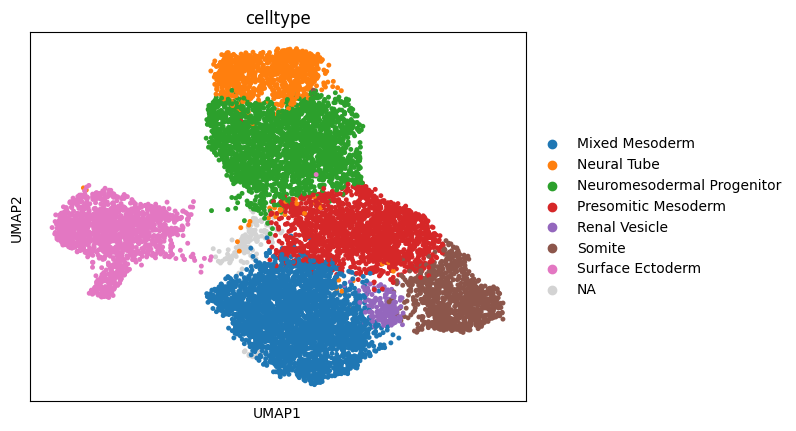

In [35]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [36]:
os.mkdir('../data/processed/GSE229103/')
adata.write('../data/processed/GSE229103/GSE229103_adata_processed.h5ad')